# アンサンブル学習
https://qiita.com/amber_kshz/items/8869d8ef7f9743b16d8d を元に実装
## バギングとAdaboost

In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## 決定株
単純な分類器として決定株を実装する

In [3]:
class DecisionStump:
    
    def __init__(self, axis=None, sign=None, threshold=None):
        self.axis = axis
        self.sign = sign
        self.threshold = threshold
    
    def fit_onedim(self, X, y, sample_weight, axis):
        
        N = len(X)
        
       
        sort_ind = np.argsort(X[:, axis])
        sorted_label = y[sort_ind]
        sorted_input = X[sort_ind]
        sorted_sample_weight = sample_weight[sort_ind]
        
        pred = -2*np.tri(N-1, N, k=0, dtype='int') + 1 
        mistakes = (pred != sorted_label ).astype('int')
        
        errs = np.zeros((2, N-1))
        errs[0] = mistakes @ sorted_sample_weight
        errs[1] = (1 - mistakes) @ sorted_sample_weight
    

        ind = np.unravel_index(np.argmin(errs, axis=None), errs.shape)
        sign = -2*ind[0] + 1
        threshold = ( sorted_input[ind[1], axis] + sorted_input[ind[1] + 1, axis] ) / 2
        err = errs[ind]
        return sign, threshold, err
    
    def fit(self, X, y, sample_weight=None):
        
        N, D = X.shape
        
        if sample_weight is None:
            sample_weight = np.ones(N)/N
        
        signs = np.zeros(D)
        threshs = np.zeros(D)
        errs = np.zeros(D)
        for axis in range(D):
            signs[axis], threshs[axis], errs[axis] = self.fit_onedim(X, y, sample_weight, axis)
        self.axis = np.argmin(errs)
        self.sign = signs[self.axis]
        self.threshold = threshs[self.axis]
    
    def predict(self, X):
        
        return self.sign*( 2*(X[:, self.axis] >= self.threshold) - 1 )

## バギング

In [5]:
class Bagging:
    def __init__(self, BaseClassifierClass, num_clfs):
        self.BaseClassifierClass = BaseClassifierClass # base classifier class
        self.num_clfs = num_clfs # ベース分類器の個数
        # ベース分類器を保存しておくためのリスト
        self.clfs = [self.BaseClassifierClass() for _ in range(self.num_clfs)]

    def fit(self, X, y):
        
        N = len(X)
        for m in range(self.num_clfs):
            
            # resampling is performed here
            sample_ind = np.random.randint(0, N, N)
            X_resampled = X[sample_ind] 
            y_resampled = y[sample_ind]
            # traing the classifier using the resampled training data
            self.clfs[m].fit(X_resampled, y_resampled)
            
    def predict(self, X):
       
        base_pred = np.zeros((self.num_clfs, len(X)))
        for m in range(self.num_clfs):
            base_pred[m] = self.clfs[m].predict(X)
        return np.sign(  np.sum(base_pred, axis = 0 ) )

## Adaboost

In [6]:
class AdaBoost:
    def __init__(self, BaseClassifierClass, num_clfs):
        self.BaseClassifierClass = BaseClassifierClass # base classifier class
        self.num_clfs = num_clfs
        self.alpha = np.zeros(self.num_clfs)
        self.clfs = [self.BaseClassifierClass() for _ in range(self.num_clfs)]
        
    def fit(self, X, y):
        
        N = len(X)
        w = np.ones(N)/N # initialize the weight
        for m in range(self.num_clfs):
            self.clfs[m].fit(X, y, sample_weight = w)
            mistakes = (self.clfs[m].predict(X) != y)
            
            # calculate the epsilon and alpha
            ep = np.sum ( w * mistakes)
            self.alpha[m] = np.log(1.0/ep - 1)
            
            # update the weight
            w = w * np.exp(  self.alpha[m] * mistakes )
            w = w/np.sum(w)
            
    def predict(self, X):
        
        base_pred = np.zeros((self.num_clfs, len(X)))
        for m in range(self.num_clfs):
            base_pred[m] = self.clfs[m].predict(X)
        return np.sign( base_pred.T @ self.alpha )
    

In [7]:
def get_meshgrid(x, y, nx, ny, margin=0.1):
    x_min, x_max = (1 + margin) * x.min() - margin * x.max(), (1 + margin) * x.max() - margin * x.min()
    y_min, y_max = (1 + margin) * y.min() - margin * y.max(), (1 + margin) * y.max() - margin * y.min()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    return xx, yy


def plot_result(ax, clf, xx, yy, X, y):
    pred = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, pred, alpha=0.7)
    ax.scatter(X[:,0], X[:,1], c=y, edgecolor='k')

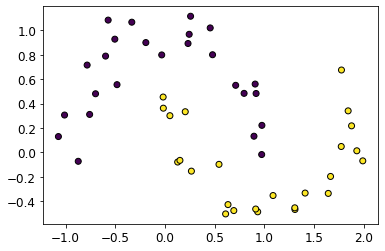

In [35]:
from sklearn import datasets
n_samples = 50
X, y = datasets.make_moons(n_samples, noise = 0.1, random_state=1)
y = 2*y-1
plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k')

xx, yy = get_meshgrid(X[:, 0], X[:, 1], nx=100, ny=100, margin=0.1)
plt.savefig(f"results/moon_data_{n_samples}.png")

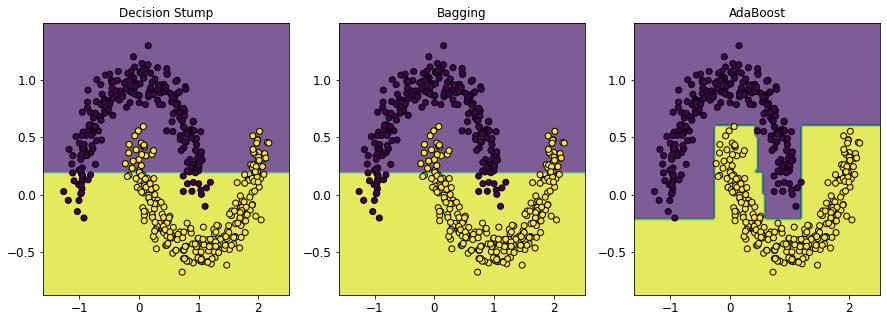

In [33]:
clfs = [DecisionStump(), Bagging(DecisionStump, 100), AdaBoost(DecisionStump, 100)]
clf_names = ['Decision Stump', 'Bagging', 'AdaBoost']

fig, axes = plt.subplots(1, 3, figsize=(15,5))

for i in range(len(clfs)):
    clfs[i].fit(X, y)
    plot_result(ax=axes[i], clf=clfs[i], xx=xx, yy=yy, X=X, y=y)
    axes[i].set_title(clf_names[i])
plt.savefig(f"results/variance_of_methods_{n_samples}")

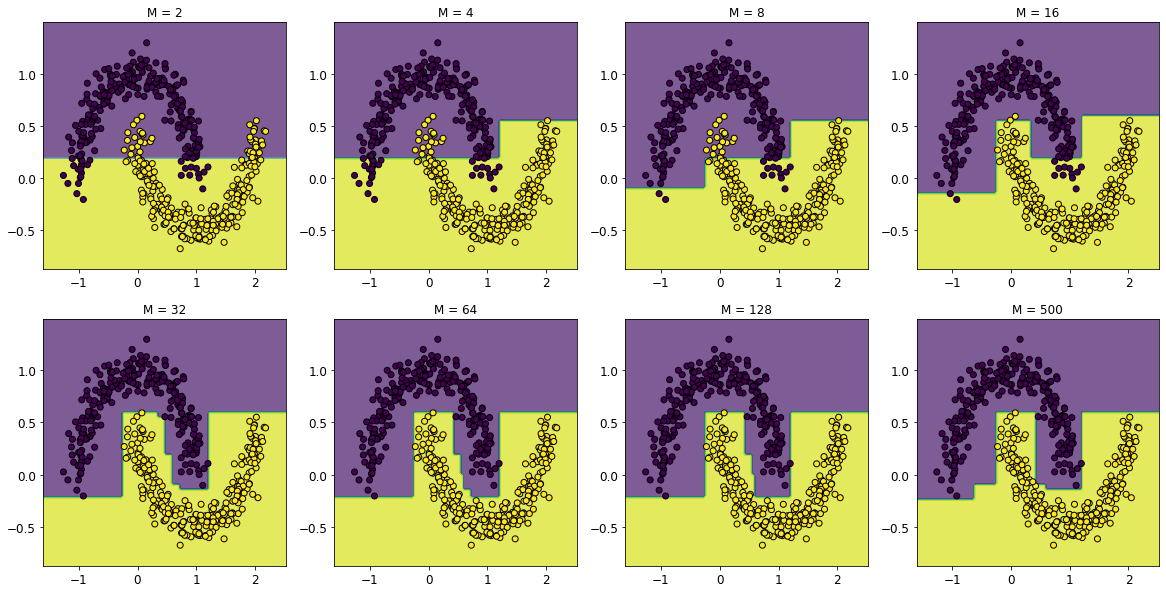

In [34]:
num_clf_list = [2, 4, 8, 16, 32, 64, 128, 500]
clfs = [AdaBoost(DecisionStump, M) for M in num_clf_list]

fig, axes = plt.subplots(2, 4, figsize=(20,10))

for i in range(len(clfs)):
    clfs[i].fit(X, y)
    plot_result(ax=np.ravel(axes)[i], clf=clfs[i], xx=xx, yy=yy, X=X, y=y)
    np.ravel(axes)[i].set_title(f'M = {num_clf_list[i]}')
plt.savefig(f"results/adaboost_difference_{n_samples}")

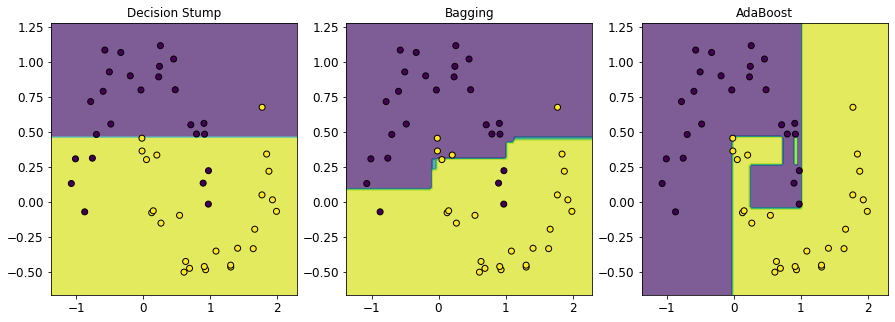

In [36]:
clfs = [DecisionStump(), Bagging(DecisionStump, 100), AdaBoost(DecisionStump, 100)]
clf_names = ['Decision Stump', 'Bagging', 'AdaBoost']

fig, axes = plt.subplots(1, 3, figsize=(15,5))

for i in range(len(clfs)):
    clfs[i].fit(X, y)
    plot_result(ax=axes[i], clf=clfs[i], xx=xx, yy=yy, X=X, y=y)
    axes[i].set_title(clf_names[i])
plt.savefig(f"results/variance_of_methods_{n_samples}")

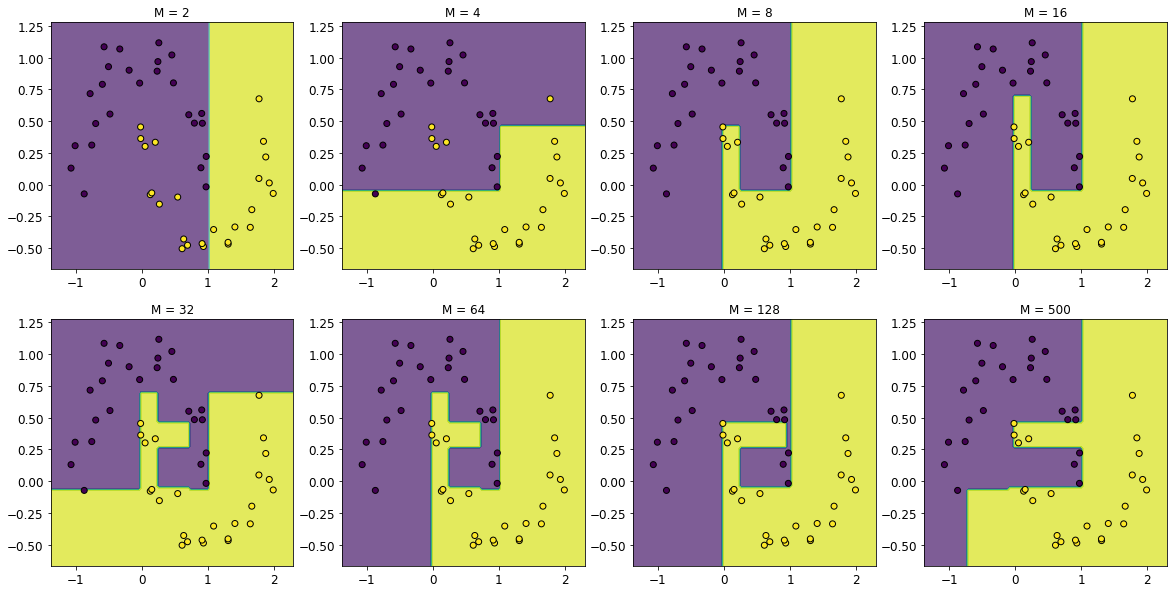

In [37]:
num_clf_list = [2, 4, 8, 16, 32, 64, 128, 500]
clfs = [AdaBoost(DecisionStump, M) for M in num_clf_list]

fig, axes = plt.subplots(2, 4, figsize=(20,10))

for i in range(len(clfs)):
    clfs[i].fit(X, y)
    plot_result(ax=np.ravel(axes)[i], clf=clfs[i], xx=xx, yy=yy, X=X, y=y)
    np.ravel(axes)[i].set_title(f'M = {num_clf_list[i]}')
plt.savefig(f"results/adaboost_difference_{n_samples}")